# Online Payments Fraud Detection

Student: Budurean Marius-Mihai

Study Program: Big Data - Data Science, Analytics ad Technologies

## Imports and Dataset Loading

In [ ]:
import pandas as pd
from pandas.api.types import is_numeric_dtype
import numpy as np
from google.colab import drive
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OrdinalEncoder
from sklearn.utils import resample
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, matthews_corrcoef
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier


import warnings
warnings.filterwarnings('ignore')

In [ ]:
drive.mount('/content/drive')
PATH = '/content/drive/MyDrive/Datasets/Online Payments Fraud Detection/online_payments_fraud_detection.csv'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df = pd.read_csv(PATH)
df = df.rename(columns={'oldbalanceOrg': 'oldbalanceOrig'})
df.head()

,step,type,amount,nameOrig,oldbalanceOrig,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


## Dataset Description

### Data Overview

Number of records, and number of attributes

In [ ]:
print(f'Number of records: {df.shape[0]}')
print(f'Number of attributes: {df.shape[1]}')

Number of records: 6362620
Number of attributes: 11


Decriptive statistics for the attributes

In [ ]:
df.describe()

,step,amount,oldbalanceOrig,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06
mean,2.433972e+02,1.798619e+05,8.338831e+05,8.551137e+05,1.100702e+06,1.224996e+06,1.290820e-03,2.514687e-06
std,1.423320e+02,6.038582e+05,2.888243e+06,2.924049e+06,3.399180e+06,3.674129e+06,3.590480e-02,1.585775e-03
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.560000e+02,1.338957e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.390000e+02,7.487194e+04,1.420800e+04,0.000000e+00,1.327057e+05,2.146614e+05,0.000000e+00,0.000000e+00
75%,3.350000e+02,2.087215e+05,1.073152e+05,1.442584e+05,9.430367e+05,1.111909e+06,0.000000e+00,0.000000e+00
max,7.430000e+02,9.244552e+07,5.958504e+07,4.958504e+07,3.560159e+08,3.561793e+08,1.000000e+00,1.000000e+00


Types of attributes

In [ ]:
metadata = []

for col in df.columns:
    col_metadata = [col, df[col].dtype]
    if 'Fraud' in col:
        col_metadata.append('binary')
    elif is_numeric_dtype(df[col]):
        col_metadata.append('numerical')
    else:
        col_metadata.append('nominal')

    col_metadata.append(df[col].isnull().sum())

    metadata.append(col_metadata)

meta_df = pd.DataFrame(metadata, columns=['name', 'data_type', 'feature_type', 'missing_values'])
meta_df

,name,data_type,feature_type,missing_values
0,step,int64,numerical,0
1,type,object,nominal,0
2,amount,float64,numerical,0
3,nameOrig,object,nominal,0
4,oldbalanceOrig,float64,numerical,0
5,newbalanceOrig,float64,numerical,0
6,nameDest,object,nominal,0
7,oldbalanceDest,float64,numerical,0
8,newbalanceDest,float64,numerical,0
9,isFraud,int64,binary,0


### Data Visualization

Histograms

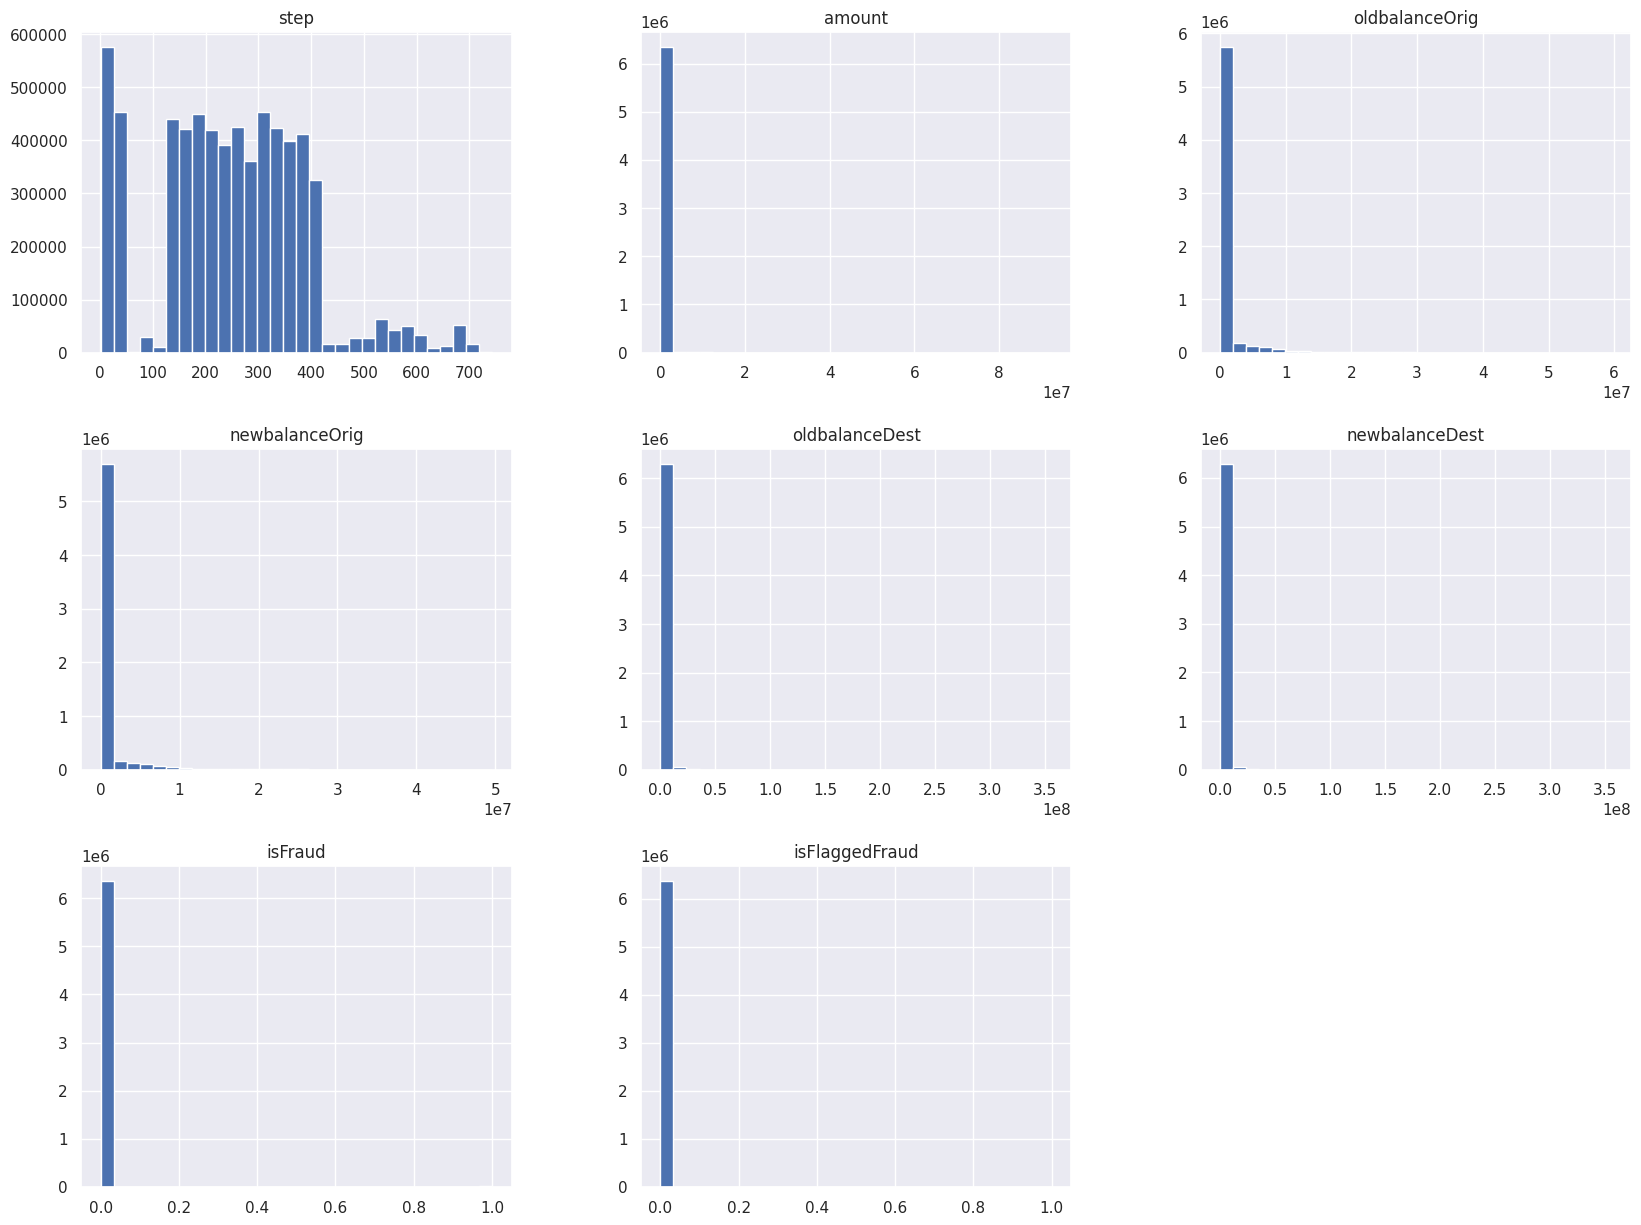

In [ ]:
df.hist(bins=30, figsize=(20, 15))
plt.show()

Box Plot of Transaction Amounts by Type

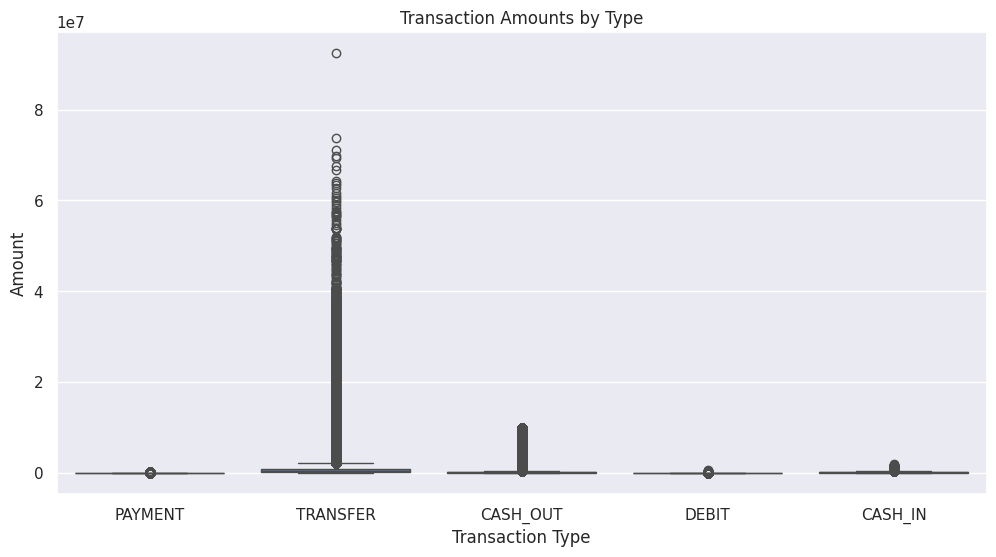

In [ ]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x='type', y='amount')
plt.title('Transaction Amounts by Type')
plt.xlabel('Transaction Type')
plt.ylabel('Amount')
plt.show()

Violin Plot of Transaction Amounts for Fraudulent vs. Non-Fraudulent Transactions

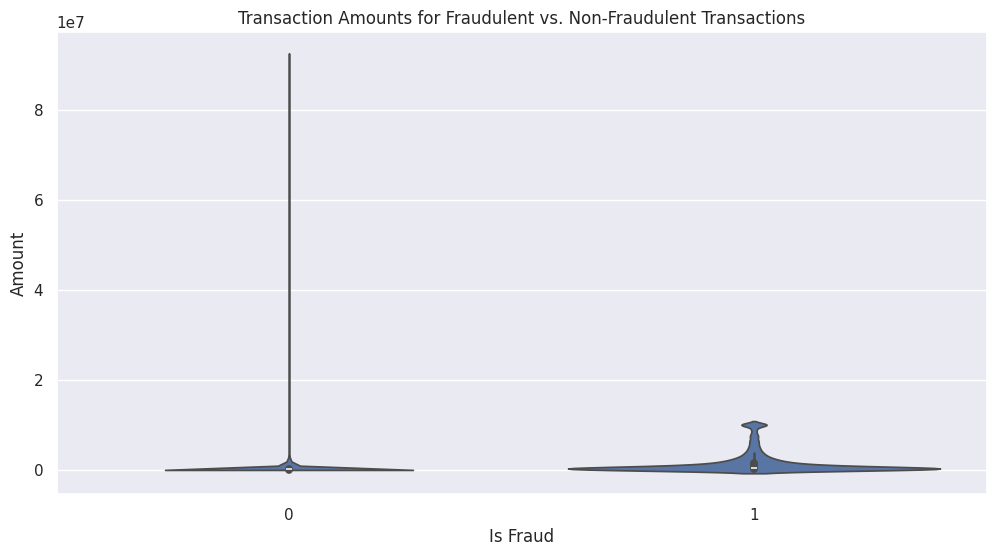

In [ ]:
plt.figure(figsize=(12, 6))
sns.violinplot(data=df, x='isFraud', y='amount')
plt.title('Transaction Amounts for Fraudulent vs. Non-Fraudulent Transactions')
plt.xlabel('Is Fraud')
plt.ylabel('Amount')
plt.show()

## Data pre-processing

### Data Conversion

Convert **type** attribute from categorical to numerical

In [ ]:
encoder = OrdinalEncoder()

df[['type']] = encoder.fit_transform(df[['type']])

df.head()

,step,type,amount,nameOrig,oldbalanceOrig,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,3.0,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,3.0,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,4.0,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,1.0,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,3.0,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


### Instance Selection

Instances from dataset where **isFraud** has value 1

In [ ]:
fraud_df = df[df.isFraud == 1]
fraud_df.shape

(8213, 11)

Instances from dataset where **isFraud** has value 0

In [ ]:
non_fraud_df = df[df.isFraud == 0]
non_fraud_df.shape

(6354407, 11)

Select a number of fraudulous instances equal to the number of non-fraudulous instances

In [ ]:
non_fraud_downsample_df = resample(non_fraud_df, replace=True, n_samples=len(fraud_df), random_state=42)
non_fraud_downsample_df.shape

(8213, 11)

Concatenate the filtered dataframes to get a balanced dataset

In [ ]:
downsampled_df = pd.concat([fraud_df, non_fraud_downsample_df])
downsampled_df.shape

(16426, 11)

### Attribute Selection

Remove the name of the actors of transactions

In [ ]:
downsampled_df = downsampled_df.drop(['nameOrig', 'nameDest'], axis=1)

Create correlation matrix to see which attributes have a greater influence on **isFraud** attribute

In [ ]:
correlation_matrix = downsampled_df.corr()
correlation_matrix.isFraud

step              0.321752
type              0.266768
amount            0.350048
oldbalanceOrig    0.130886
newbalanceOrig   -0.127499
oldbalanceDest   -0.083167
newbalanceDest   -0.000593
isFraud           1.000000
isFlaggedFraud    0.031225
Name: isFraud, dtype: float64

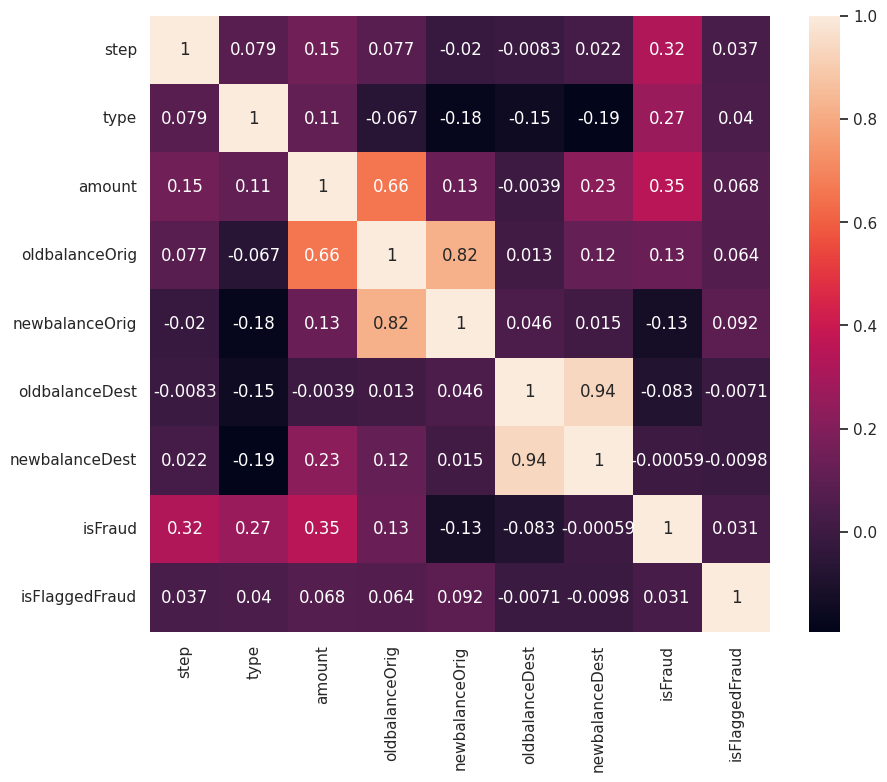

In [ ]:
sns.set(rc={"figure.figsize":(10, 8)})
ax = sns.heatmap(correlation_matrix, annot=True)

Remove the attributes with small values in the correlation matrix

In [ ]:
downsampled_df = downsampled_df.drop(['newbalanceOrig', 'oldbalanceDest', 'newbalanceDest'], axis=1)
downsampled_df.head()

,step,type,amount,oldbalanceOrig,isFraud,isFlaggedFraud
2,1,4.0,181.0,181.0,1,0
3,1,1.0,181.0,181.0,1,0
251,1,4.0,2806.0,2806.0,1,0
252,1,1.0,2806.0,2806.0,1,0
680,1,4.0,20128.0,20128.0,1,0


### Train Test Split

Split the dataset into train and test

In [ ]:
x_attr = ['step', 'type', 'amount', 'oldbalanceOrig', 'isFlaggedFraud']
x = downsampled_df[x_attr]
y = downsampled_df[['isFraud']]

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.7)

## Classifiers

Function to compute metrics for a ML model

In [ ]:
def specificity(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return tn / (tn + fp)

def get_metrics(y_test, y_pred):
    metrics = {}
    metrics['Accuracy'] = accuracy_score(y_test, y_pred)
    metrics['Sensitivity/Recall'] = recall_score(y_test, y_pred)
    metrics['Specificity'] = specificity(y_test, y_pred)
    metrics['Precision'] = precision_score(y_test, y_pred)
    metrics['F1 Score'] = f1_score(y_test, y_pred)
    metrics['MCC'] = matthews_corrcoef(y_test, y_pred)
    return metrics

Cross-Validation function

In [ ]:
def model_cross_validation(model, x, y, cv = 10):
    acc_cv = cross_val_score(model, x, y.values.ravel(), cv=cv)
    return np.mean(acc_cv), np.std(acc_cv)

### K-Nearest Neighbors

Function to test the influence of **n_neighbors**

In [ ]:
knn_dict = {
    'Neighbors': [],
    'Accuracy': [],
    'Sensitivity/Recall': [],
    'Specificity': [],
    'Precision': [],
    'F1 Score': [],
    'MCC': [],
    'Mean Accuracy': [],
    'Mean Stdev Accuracy': []
}

In [ ]:
for k in range(2, 21):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(x_train, y_train.values.ravel())
    res_knn = knn.predict(x_test)

    knn_dict['Neighbors'].append(k)

    metrics_knn = get_metrics(y_test, res_knn)

    for k, v in metrics_knn.items():
        knn_dict[k].append(v)

    mean_acc, mean_stdev_acc = model_cross_validation(knn, x, y,)
    knn_dict['Mean Accuracy'].append(mean_acc)
    knn_dict['Mean Stdev Accuracy'].append(mean_stdev_acc)

In [ ]:
knn_df = pd.DataFrame(knn_dict)
knn_df.head(19)

,Neighbors,Accuracy,Sensitivity/Recall,Specificity,Precision,F1 Score,MCC,Mean Accuracy,Mean Stdev Accuracy
0,2,0.988028,0.992686,0.983381,0.983494,0.988069,0.976098,0.986912,0.008066
1,3,0.987622,0.997562,0.977706,0.978088,0.987729,0.975437,0.988860,0.004155
2,4,0.986607,0.995124,0.978111,0.978426,0.986704,0.973356,0.987277,0.006957
3,5,0.983969,0.996749,0.971220,0.971870,0.984152,0.968256,0.986242,0.005278
4,6,0.983766,0.996343,0.971220,0.971859,0.983949,0.967840,0.986303,0.005321
5,7,0.981331,0.997562,0.965140,0.966155,0.981607,0.963172,0.985024,0.005215
6,8,0.981331,0.997156,0.965545,0.966522,0.981600,0.963146,0.984537,0.006685
7,9,0.979505,0.997562,0.961492,0.962745,0.979844,0.959638,0.983076,0.006341
8,10,0.979505,0.997562,0.961492,0.962745,0.979844,0.959638,0.983015,0.006292
9,11,0.978287,0.997562,0.959060,0.960485,0.978673,0.957288,0.981919,0.006330


Implementation of the best version of K-Nearest Neighbors (k = 4)

In [ ]:
knn = KNeighborsClassifier(n_neighbors=4)

In [ ]:
knn.fit(x_train, y_train.values.ravel())

KNeighborsClassifier(n_neighbors=4)

In [ ]:
res_knn = knn.predict(x_test)

In [ ]:
metrics_knn = get_metrics(y_test, res_knn)
print("Metrics for K-Nearest Neighbors:")
for k, v in metrics_knn.items():
    print(f'{k}: {v}')

Metrics for K-Nearest Neighbors:
Accuracy: 0.9866071428571429
Sensitivity/Recall: 0.9951239333604226
Specificity: 0.9781110660721524
Precision: 0.9784258889332801
F1 Score: 0.9867042707493956
MCC: 0.9733562098308012


In [ ]:
mean_acc, mean_stdev_acc = model_cross_validation(knn, x, y)
print(f'mean_acc = {mean_acc}, mean_stdev_acc = {mean_stdev_acc}')

mean_acc = 0.9872770317806395, mean_stdev_acc = 0.006957119637142524


### Logistic Regression

Function to test the influence of different solvers

In [ ]:
log_reg_dict = {
    'Solver': [],
    'Accuracy': [],
    'Sensitivity/Recall': [],
    'Specificity': [],
    'Precision': [],
    'F1 Score': [],
    'MCC': [],
    'Mean Accuracy': [],
    'Mean Stdev Accuracy': []
}

solvers = ['liblinear', 'sag', 'saga', 'newton-cg', 'lbfgs']

In [ ]:
for s in solvers:
    log_reg = LogisticRegression(solver=s)
    log_reg.fit(x_train, y_train.values.ravel())
    res_log_reg = log_reg.predict(x_test)

    log_reg_dict['Solver'].append(s)

    metrics_log_reg = get_metrics(y_test, res_log_reg)

    for k, v in metrics_log_reg.items():
        log_reg_dict[k].append(v)

    mean_acc, mean_stdev_acc = model_cross_validation(log_reg, x, y,)
    log_reg_dict['Mean Accuracy'].append(mean_acc)
    log_reg_dict['Mean Stdev Accuracy'].append(mean_stdev_acc)

In [ ]:
log_reg_df = pd.DataFrame(log_reg_dict)
log_reg_df.head(len(solvers))

,Solver,Accuracy,Sensitivity/Recall,Specificity,Precision,F1 Score,MCC,Mean Accuracy,Mean Stdev Accuracy
0,liblinear,0.617289,0.997562,0.237941,0.566321,0.722484,0.361922,0.616888,0.005196
1,sag,0.617086,0.997968,0.237130,0.566160,0.722459,0.362092,0.616401,0.005700
2,saga,0.617086,0.997968,0.237130,0.566160,0.722459,0.362092,0.616401,0.005700
3,newton-cg,0.794846,0.699716,0.889745,0.863591,0.773064,0.600485,0.783967,0.117407
4,lbfgs,0.617086,0.997968,0.237130,0.566160,0.722459,0.362092,0.614330,0.005572


Implementation of the best version of Logistic Regression (solver = newton-cg)

In [ ]:
log_reg = LogisticRegression(solver='newton-cg')

In [ ]:
log_reg.fit(x_train, y_train.isFraud)

LogisticRegression(solver='newton-cg')

In [ ]:
res_log_reg = log_reg.predict(x_test)

In [ ]:
metrics_log_reg = get_metrics(y_test, res_log_reg)
print("Metrics for Logistic Regression:")
for k, v in metrics_log_reg.items():
    print(f'{k}: {v}')

Metrics for Logistic Regression:
Accuracy: 0.7948457792207793
Sensitivity/Recall: 0.699715562779358
Specificity: 0.8897446291041751
Precision: 0.8635907723169508
F1 Score: 0.7730639730639731
MCC: 0.6004850936213824


In [ ]:
mean_acc, mean_stdev_acc = model_cross_validation(log_reg, x, y)
print(f'mean_acc = {mean_acc}, mean_stdev_acc = {mean_stdev_acc}')

mean_acc = 0.7839673052843681, mean_stdev_acc = 0.11740687363705267


### Decision Tree

Function to test the influence of criterion and splitter

In [ ]:
dec_tree_dict = {
    'Criterion': [],
    'Splitter': [],
    'Accuracy': [],
    'Sensitivity/Recall': [],
    'Specificity': [],
    'Precision': [],
    'F1 Score': [],
    'MCC': [],
    'Mean Accuracy': [],
    'Mean Stdev Accuracy': []
}

criterions = ['gini', 'entropy', 'log_loss']
splitters = ['best', 'random']

In [ ]:
for c in criterions:
    for s in splitters:
        dec_tree = DecisionTreeClassifier(criterion=c, splitter=s)
        dec_tree.fit(x_train, y_train.values.ravel())
        res_dec_tree = dec_tree.predict(x_test)

        dec_tree_dict['Criterion'].append(c)
        dec_tree_dict['Splitter'].append(s)

        metrics_dec_tree = get_metrics(y_test, res_dec_tree)

        for k, v in metrics_dec_tree.items():
            dec_tree_dict[k].append(v)

        mean_acc, mean_stdev_acc = model_cross_validation(dec_tree, x, y,)
        dec_tree_dict['Mean Accuracy'].append(mean_acc)
        dec_tree_dict['Mean Stdev Accuracy'].append(mean_stdev_acc)

In [ ]:
dec_tree_df = pd.DataFrame(dec_tree_dict)
dec_tree_df.head(len(criterions) * len(splitters))

,Criterion,Splitter,Accuracy,Sensitivity/Recall,Specificity,Precision,F1 Score,MCC,Mean Accuracy,Mean Stdev Accuracy
0,gini,best,0.974026,0.975620,0.972436,0.972458,0.974037,0.948057,0.866329,0.111782
1,gini,random,0.977476,0.983746,0.971220,0.971509,0.977589,0.955028,0.833370,0.100343
2,entropy,best,0.977273,0.981715,0.972842,0.973017,0.977346,0.954584,0.865962,0.101195
3,entropy,random,0.979099,0.984965,0.973247,0.973494,0.979196,0.958265,0.865585,0.101157
4,log_loss,best,0.978287,0.982934,0.973652,0.973833,0.978362,0.956617,0.866145,0.101451
5,log_loss,random,0.979708,0.990248,0.969193,0.969757,0.979895,0.959630,0.872029,0.115295


Implementation of the best Decision Tree Classifier (criterion = log_loss, splitter = random)

In [ ]:
dec_tree = DecisionTreeClassifier(criterion='log_loss', splitter='random')

In [ ]:
dec_tree.fit(x_train, y_train.values.ravel())

DecisionTreeClassifier(criterion='log_loss', splitter='random')

In [ ]:
res_dec_tree = dec_tree.predict(x_test)

In [ ]:
metrics_dec_tree = get_metrics(y_test, res_dec_tree)
print("Metrics for Decision Tree:")
for k, v in metrics_dec_tree.items():
    print(f'{k}: {v}')

Metrics for Decision Tree:
Accuracy: 0.9724025974025974
Sensitivity/Recall: 0.9760260056887444
Specificity: 0.9687880016214026
Precision: 0.9689390883420734
F1 Score: 0.9724696356275303
MCC: 0.9448308147243902


In [ ]:
mean_acc, mean_stdev_acc = model_cross_validation(dec_tree, x, y)
print(f'mean_acc = {mean_acc}, mean_stdev_acc = {mean_stdev_acc}')

mean_acc = 0.8543940149884758, mean_stdev_acc = 0.13024848340357376
